/opt/anaconda3/envs/Python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch 1/10, Training Loss: 0.5554000021160213, Validation Loss: 0.28260878883536505
Epoch 2/10, Training Loss: 0.23765592114361897, Validation Loss: 0.2024294916516955
Epoch 3/10, Training Loss: 0.20594541749616307, Validation Loss: 0.18725562343994775
Epoch 4/10, Training Loss: 0.18506771200226518, Validation Loss: 0.1459564891579391
Epoch 5/10, Training Loss: 0.18750691556877744, Validation Loss: 0.16186392423257512
Epoch 6/10, Training Loss: 0.16657858703314787, Validation Loss: 0.16205897319874485
Epoch 7/10, Training Loss: 0.148853806596924, Validation Loss: 0.1348113814462562
Epoch 8/10, Training Loss: 0.1441736741988795, Validation Loss: 0.13896590173713066
Epoch 9/10, Training Loss: 0.14268449804210287, Validation Loss: 0.11623151711065252
Epoch 10/10, Training Loss: 0.17346548730742156, Validation Loss: 0.15493795425636964


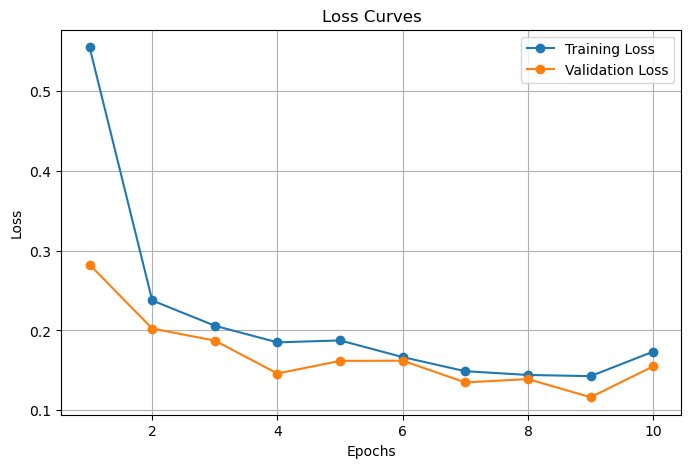

In [1]:
import os
import torchaudio

import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d

label_file_path = "/Users/zhuohangchen/Downloads/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
audio_dir_path = "/Users/zhuohangchen/Downloads/LA/ASVspoof2019_LA_train/flac"

# Dictionary to store audio file labels.
audio_labels = {}

# Read the labels from the text file and store them in the dictionary.
with open(label_file_path, 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 5 and parts[4] in ['bonafide', 'spoof']:
            audio_id = parts[1]
            label = 0 if parts[4] == 'bonafide' else 1
            audio_labels[audio_id] = label

# Dictionary 'audio_labels' where keys are audio IDs.
# and values are labels (0 for genuine, 1 for spoofed).


# List to store audio filenames and corresponding labels.
audio_filenames = []
labels = []

# Iterate through the audio directory to find the audio files.
for filename in os.listdir(audio_dir_path):
    if filename.endswith('.flac'):
        audio_id = filename.split('.')[0]
        if audio_id in audio_labels:
            audio_file_path = os.path.join(audio_dir_path, filename)
            audio_filenames.append(audio_file_path)
            labels.append(audio_labels[audio_id])
            

class AudioDataset(Dataset):
    def __init__(self, audio_filenames, labels):
        self.audio_filenames = audio_filenames
        self.labels = labels
        self.sr = 16000  # Sample rate for resampling.
        self.max_seq_len = 200  # Maximum sequence length for padding.

    def __len__(self):
        return len(self.audio_filenames)

    def __getitem__(self, idx):
        audio_filename = self.audio_filenames[idx]
        waveform, sample_rate = torchaudio.load(audio_filename)
        waveform = waveform.numpy()
        waveform = waveform.squeeze()




        # Resample the audio waveform if needed
        if sample_rate != self.sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sr)
            waveform = resampler(waveform)

        # Compute Log-Mel Spectrogram using librosa instead of MFCC.
        melspectrogram = librosa.feature.melspectrogram(y=waveform, sr=self.sr, n_mels=40)  # Adjust n_mels as required
        log_melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)

        # Pad or truncate the log-mel spectrogram to the maximum sequence length.
        if log_melspectrogram.shape[1] < self.max_seq_len:
            log_melspectrogram = np.pad(log_melspectrogram, ((0, 0), (0, self.max_seq_len - log_melspectrogram.shape[1])), mode='constant')
        else:
            log_melspectrogram = log_melspectrogram[:, :self.max_seq_len]

        # Convert log-mel spectrogram to tensor.
        features_tensor = torch.tensor(log_melspectrogram)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return features_tensor, label


class SimpleAudioClassifier(nn.Module):
    def __init__(self, num_mels, max_seq_len):
        super(SimpleAudioClassifier, self).__init__()
        self.num_mels = num_mels
        self.max_seq_len = max_seq_len
        self.fc1 = nn.Linear(num_mels * max_seq_len, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)  # Additional hidden layer
        self.fc4 = nn.Linear(32, 2)  # 2 output classes: genuine or spoofed

    def forward(self, x):
        x = x.view(-1, self.num_mels * self.max_seq_len)  # Flatten the log-mel spectrogram
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))  # Applying ReLU activation to the output of the additional hidden layer
        x = self.fc4(x)
        return x


    
    
num_mels = 40
dataset = AudioDataset(audio_filenames, labels)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)


model = SimpleAudioClassifier(num_mels=64, max_seq_len=125)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)




# Splitting the data into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% of data for training
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Variables for early stopping
early_stop_patience = 5
no_improve = 0
best_val_loss = float('inf')

# Training loop with validation
train_loss_history = []
val_loss_history = []
num_epochs=10
for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0.0
    for mfcc_batch, label_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(mfcc_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    
    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for mfcc_batch, label_batch in val_loader:
            outputs = model(mfcc_batch)
            loss = criterion(outputs, label_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    # Checkpoint and Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "logmel_model.pth")  
        no_improve = 0
    else:
        no_improve += 1

    if no_improve == early_stop_patience:
        print("Early stopping!")
        break

# Plot the training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, marker='o', label='Training Loss')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, marker='o', label='Validation Loss')
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Testing Accuracy: 85.87%
Equal Error Rate (EER): 0.1723


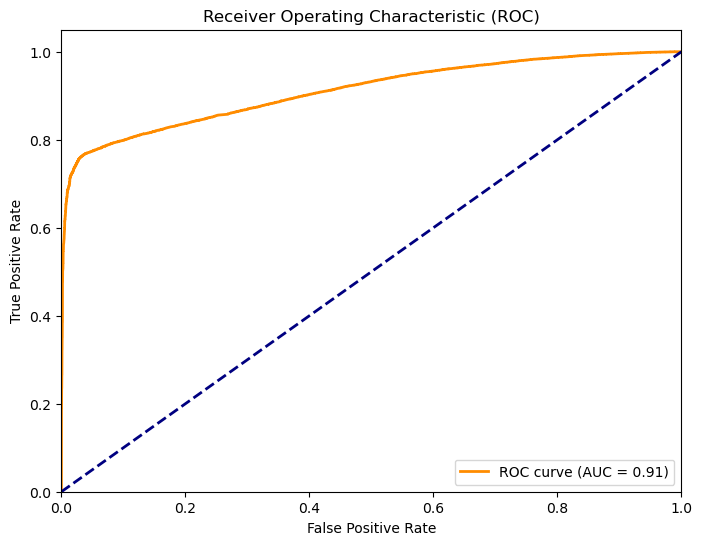

Area Under the ROC Curve (AUC): 0.9106


In [2]:

def test_model(model, test_data_loader):
    model.eval()  # Set the model to evaluation mode.
    correct = 0
    total = 0

    with torch.no_grad():
        for logmel_batch, label_batch in test_data_loader:
            outputs = model(logmel_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += label_batch.size(0)
            correct += (predicted == label_batch).sum().item()

    accuracy = 100 * correct / total
    print(f"Testing Accuracy: {accuracy:.2f}%")

# Path to the testing audio directory and labels file.
test_audio_dir = "/Users/zhuohangchen/Downloads/LA/ASVspoof2019_LA_eval/flac"
test_labels_file = "/Users/zhuohangchen/Downloads/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

# Load the testing audio filenames and labels.
test_audio_filenames = []
test_labels = []

with open(test_labels_file, 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 5 and parts[4] in ['bonafide', 'spoof']:
            audio_id = parts[1]
            label = 0 if parts[4] == 'bonafide' else 1
            audio_file_path = os.path.join(test_audio_dir, f"{audio_id}.flac")
            if os.path.exists(audio_file_path):
                test_audio_filenames.append(audio_file_path)
                test_labels.append(label)

# Create the testing dataset and data loader.
test_dataset = AudioDataset(test_audio_filenames, test_labels)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the model weights from the trained model.
model = SimpleAudioClassifier(num_mels=64, max_seq_len=125)
model.load_state_dict(torch.load("logmel_model.pth"))

# Test the model on the testing data.
test_model(model, test_data_loader)

# Function to calculate Equal Error Rate (EER)
def calculate_eer(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

# Function to plot ROC curve and calculate AUC
def plot_roc_auc(labels, scores):
    fpr, tpr, _ = roc_curve(labels, scores, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

model.eval()
labels = []  # True labels (0 for genuine, 1 for spoofed)
scores = []  # Model's predicted scores

with torch.no_grad():
    for logmel_batch, label_batch in test_data_loader:
        outputs = model(logmel_batch)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        scores.extend(probabilities.cpu().numpy())
        labels.extend(label_batch.cpu().numpy())

# Calculate EER
eer = calculate_eer(labels, scores)
print(f'Equal Error Rate (EER): {eer:.4f}')

# Plot ROC curve and calculate AUC
plot_roc_auc(labels, scores)
roc_auc = roc_auc_score(labels, scores)
print(f'Area Under the ROC Curve (AUC): {roc_auc:.4f}')




Equal Error Rate (EER): 0.5354


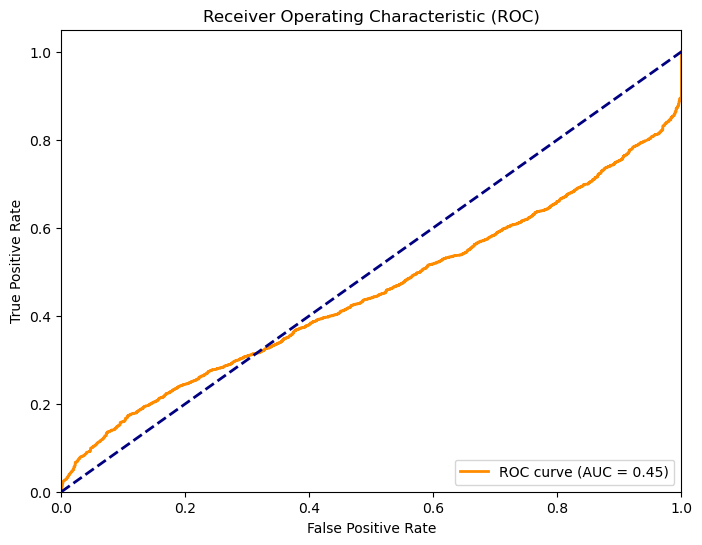

Area Under the ROC Curve (AUC): 0.4493
Testing Accuracy: 74.64%


In [3]:
test_audio_dir = "/Users/zhuohangchen/Downloads/ASVspoof2017_V2_eval"
test_labels_file = "/Users/zhuohangchen/Downloads/protocol_V2/ASVspoof2017_V2_eval.trl.txt"

test_audio_filenames = []
test_labels = []

with open(test_labels_file, 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) >= 2 and parts[1] in ['spoof', 'genuine']:
            audio_id = parts[0].split('.')[0]
            label = 0 if parts[1] == 'genuine' else 1
            audio_file_path = os.path.join(test_audio_dir, f"{audio_id}.wav")
            if os.path.exists(audio_file_path):
                test_audio_filenames.append(audio_file_path)
                test_labels.append(label)


test_dataset = AudioDataset(test_audio_filenames, test_labels)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


model = SimpleAudioClassifier(num_mels=64, max_seq_len=125)
model.load_state_dict(torch.load("/Users/zhuohangchen/Downloads/logmel_model.pth"))


model.eval()
labels = []
scores = []

with torch.no_grad():
    for mfcc_batch, label_batch in test_data_loader:
        outputs = model(mfcc_batch)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        scores.extend(probabilities.cpu().numpy())
        labels.extend(label_batch.cpu().numpy())

# Calculate EER
eer = calculate_eer(labels, scores)
print(f'Equal Error Rate (EER): {eer:.4f}')

# Plot ROC curve and calculate AUC
plot_roc_auc(labels, scores)
roc_auc = roc_auc_score(labels, scores)
print(f'Area Under the ROC Curve (AUC): {roc_auc:.4f}')


test_model(model, test_data_loader)